<a href="https://colab.research.google.com/github/kurtsenol/machine-learning/blob/master/LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import numpy as np
import pandas as pd

In [0]:
DATA_PATH = 'drive/My Drive/nipstxt/'

In [4]:
folders = ["nips{0:02}".format(i) for i in range(0,13)]
folders

['nips00',
 'nips01',
 'nips02',
 'nips03',
 'nips04',
 'nips05',
 'nips06',
 'nips07',
 'nips08',
 'nips09',
 'nips10',
 'nips11',
 'nips12']

In [0]:
# # Read all texts into a list.
# papers = []

# for folder in folders:
#   file_names = os.listdir(DATA_PATH + folder)
#   for file_name in file_names:
#     with open(DATA_PATH + folder + '/' + file_name, encoding='utf-8', errors='ignore', mode='r+') as f:
#       data = f.read()
#     papers.append(data)
# len(papers)

In [0]:
import pickle

In [0]:
# with open("drive/My Drive/nipstxt/papers_pickle.txt", "wb") as fp:   #Pickling
#   pickle.dump(papers, fp)

In [0]:
with open("drive/My Drive/nipstxt/papers_pickle.txt", "rb") as fp:   # Unpickling
  papers = pickle.load(fp)

In [9]:
len(papers)

1740

In [10]:
print(papers[0][:1000])

1 
CONNECTIVITY VERSUS ENTROPY 
Yaser S. Abu-Mostafa 
California Institute of Technology 
Pasadena, CA 91125 
ABSTRACT 
How does the connectivity of a neural network (number of synapses per 
neuron) relate to the complexity of the problems it can handle (measured by 
the entropy)? Switching theory would suggest no relation at all, since all Boolean 
functions can be implemented using a circuit with very low connectivity (e.g., 
using two-input NAND gates). However, for a network that learns a problem 
from examples using a local learning rule, we prove that the entropy of the 
problem becomes a lower bound for the connectivity of the network. 
INTRODUCTION 
The most distinguishing feature of neural networks is their ability to spon- 
taneously learn the desired function from 'training' samples, i.e., their ability 
to program themselves. Clearly, a given neural network cannot just learn any 
function, there must be some restrictions on which networks can learn which 
functions. One obv

In [11]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
stop_words = nltk.corpus.stopwords.words('english')
wtk = nltk.tokenize.RegexpTokenizer(r'\w+')
wnl = nltk.stem.wordnet.WordNetLemmatizer()

In [0]:
def normalize_corpus(papers):
  norm_papers = []
  for paper in papers:
    paper = paper.lower()
    paper_tokens = [token.strip() for token in wtk.tokenize(paper)]
    paper_tokens = [wnl.lemmatize(token) for token in paper_tokens if not token.isnumeric()]
    paper_tokens = [token for token in paper_tokens if len(token) > 1]
    paper_tokens = [token for token in paper_tokens if token not in stop_words]
    
    paper_tokens = list(filter(None, paper_tokens))
    if paper_tokens:
      norm_papers.append(paper_tokens)
  return norm_papers

In [14]:
norm_papers = normalize_corpus(papers)
print(len(norm_papers))

1740


In [15]:
# viewing a processed paper
print(norm_papers[0][:50])

['connectivity', 'versus', 'entropy', 'yaser', 'abu', 'mostafa', 'california', 'institute', 'technology', 'pasadena', 'ca', 'abstract', 'doe', 'connectivity', 'neural', 'network', 'number', 'synapsis', 'per', 'neuron', 'relate', 'complexity', 'problem', 'handle', 'measured', 'entropy', 'switching', 'theory', 'would', 'suggest', 'relation', 'since', 'boolean', 'function', 'implemented', 'using', 'circuit', 'low', 'connectivity', 'using', 'two', 'input', 'nand', 'gate', 'however', 'network', 'learns', 'problem', 'example', 'using']


In [0]:
import gensim


In [0]:
bigram = gensim.models.Phrases(norm_papers, min_count=20, threshold=20, delimiter=b'_') # higher threshold fewer phrases.
bigram_model = gensim.models.phrases.Phraser(bigram)

In [18]:
# sample demonstration
print(bigram_model[norm_papers[0]][:50])

['connectivity', 'versus', 'entropy', 'yaser', 'abu_mostafa', 'california_institute', 'technology_pasadena', 'ca_abstract', 'doe', 'connectivity', 'neural_network', 'number', 'synapsis', 'per', 'neuron', 'relate', 'complexity', 'problem', 'handle', 'measured', 'entropy', 'switching', 'theory', 'would', 'suggest', 'relation', 'since', 'boolean_function', 'implemented', 'using', 'circuit', 'low', 'connectivity', 'using', 'two', 'input', 'nand', 'gate', 'however', 'network', 'learns', 'problem', 'example', 'using', 'local', 'learning', 'rule', 'prove', 'entropy', 'problem']


Let’s generate phrases for all our tokenized research papers and build a vocabulary that will help us obtain a unique term/phrase to number mapping (since machine or deep learning only works on numeric tensors).

In [0]:
norm_corpus_bigrams = [bigram_model[doc] for doc in norm_papers]

In [20]:
# Create a dictionary representation of the documents.
dictionary = gensim.corpora.Dictionary(norm_corpus_bigrams)

print('Sample word to number mappings:', list(dictionary.items())[:15])
print('Total Vocabulary Size:', len(dictionary))

Sample word to number mappings: [(0, '0a'), (1, '2h'), (2, '2h2'), (3, '2he'), (4, '2n'), (5, '__c'), (6, '_c'), (7, '_k'), (8, 'a2'), (9, 'ability'), (10, 'abu_mostafa'), (11, 'access'), (12, 'accommodate'), (13, 'according'), (14, 'accumulated')]
Total Vocabulary Size: 78892


Several of these terms are not very useful since they are specific to a paper or even a paragraph in a research paper. Hence, it is time to prune
our vocabulary and start removing terms. Leveraging document frequency is a great way to achieve this. By now, you probably realize that the document frequency of a term is basically the total number of times that term occurs across all the documents in a corpus.

In [21]:
# Filter out words that occur less than 20 documents, or more than 50% of the documents.

dictionary.filter_extremes(no_below=20, no_above=0.6)

print('Total Vocabulary Size:', len(dictionary))

Total Vocabulary Size: 7756


In [22]:
print('Sample word to number mappings:', list(dictionary.items())[:15])

Sample word to number mappings: [(0, '2n'), (1, '_c'), (2, 'a2'), (3, 'ability'), (4, 'abu_mostafa'), (5, 'access'), (6, 'accommodate'), (7, 'according'), (8, 'accumulated'), (9, 'acknowledgement_work'), (10, 'addison_wesley'), (11, 'afosr'), (12, 'aip'), (13, 'air_force'), (14, 'although')]


We removed all terms that occur fewer than 20 times across all documents and all
terms that occur in more than 60% of all the documents. We are interested in finding different themes and topics and not recurring themes. Hence, this suits our scenario perfectly. We can now perform feature engineering by leveraging a simple Bag of Words model.

In [23]:
# Transforming corpus into bag of words vectors

bow_corpus = [dictionary.doc2bow(text) for text in norm_corpus_bigrams]
print(bow_corpus[1][:50])

[(3, 2), (4, 1), (11, 1), (13, 1), (15, 1), (21, 1), (27, 1), (30, 1), (33, 1), (35, 2), (36, 1), (45, 1), (46, 1), (47, 1), (48, 2), (57, 2), (64, 7), (67, 4), (71, 3), (78, 1), (92, 3), (94, 2), (97, 9), (104, 1), (113, 1), (115, 4), (118, 4), (120, 2), (124, 4), (125, 3), (128, 1), (133, 5), (136, 3), (138, 1), (142, 3), (144, 6), (152, 2), (155, 1), (156, 1), (158, 1), (162, 1), (168, 1), (172, 1), (177, 12), (199, 1), (203, 14), (204, 1), (213, 1), (215, 1), (218, 4)]


In [24]:
# viewing actual terms and their counts
print([(dictionary[idx] , freq) for idx, freq in bow_corpus[1][:50]])

[('ability', 2), ('abu_mostafa', 1), ('afosr', 1), ('air_force', 1), ('american_institute', 1), ('appendix', 1), ('assume', 1), ('asymptotic', 1), ('axe', 1), ('become', 2), ('becomes', 1), ('bt', 1), ('ca_abstract', 1), ('california_institute', 1), ('cannot', 2), ('complete', 2), ('connected', 7), ('consider', 4), ('corresponding', 3), ('denote', 1), ('ea', 3), ('ed', 2), ('element', 9), ('environment', 1), ('expected', 1), ('expression', 4), ('fact', 4), ('final', 2), ('fixed', 4), ('follows', 3), ('furthermore', 1), ('get', 5), ('go', 3), ('going', 1), ('hand', 3), ('hence', 6), ('implemented', 2), ('independent', 1), ('independently', 1), ('interested', 1), ('ity', 1), ('know', 1), ('le', 1), ('let', 12), ('need', 1), ('neuron', 14), ('next_section', 1), ('occur', 1), ('office_scientific', 1), ('otherwise', 4)]


In [25]:
# total papers in the corpus

print('Total number of papers:', len(bow_corpus))

Total number of papers: 1740


### Latent Dirichlet Allocation

In [0]:
TOTAL_TOPICS = 10

In [0]:
lda_model = gensim.models.LdaModel(corpus=bow_corpus, id2word=dictionary, chunksize=1740, alpha='auto',
                                   eta='auto', random_state=42, iterations=500, num_topics=TOTAL_TOPICS,
                                   passes=20, eval_every=None)

Viewing the topics in our trained topic model is quite easy and we can generate them with the following code.

In [28]:
for topic_id, topic in lda_model.print_topics(num_topics=10, num_words=20):
  print('Topic #'+str(topic_id+1)+':')
  print(topic)
  print()

Topic #1:
0.014*"control" + 0.008*"unit" + 0.007*"state" + 0.007*"trajectory" + 0.006*"target" + 0.006*"dynamic" + 0.006*"movement" + 0.006*"motor" + 0.005*"position" + 0.005*"module" + 0.005*"task" + 0.005*"controller" + 0.005*"representation" + 0.004*"pattern" + 0.004*"change" + 0.004*"subject" + 0.004*"hand" + 0.004*"behavior" + 0.004*"arm" + 0.003*"activation"

Topic #2:
0.012*"chip" + 0.011*"circuit" + 0.008*"image" + 0.007*"current" + 0.007*"neuron" + 0.006*"voltage" + 0.006*"analog" + 0.004*"processor" + 0.004*"signal" + 0.004*"implementation" + 0.004*"bit" + 0.004*"design" + 0.004*"pixel" + 0.004*"line" + 0.003*"vector" + 0.003*"neural" + 0.003*"device" + 0.003*"digital" + 0.003*"application" + 0.003*"architecture"

Topic #3:
0.027*"state" + 0.014*"action" + 0.009*"policy" + 0.008*"control" + 0.007*"step" + 0.007*"reinforcement_learning" + 0.006*"optimal" + 0.005*"task" + 0.005*"environment" + 0.004*"reward" + 0.004*"goal" + 0.004*"agent" + 0.004*"td" + 0.004*"cost" + 0.004*"ro

all the weights are the same sign and tell us the importance of each term in the topic. We can also view the overall mean coherence score of the model.

In [29]:
topics_coherences = lda_model.top_topics(bow_corpus, topn=20)

avg_coherence_score = np.mean([item[1] for item in topics_coherences])

print('Avg. Coherence Score:', avg_coherence_score)

Avg. Coherence Score: -1.0190235012946323


Let’s now look at the output of our LDA topic model in an easier to understand format. One way is to visualize the topics as tuples of terms and weights.

In [30]:
topics_with_wts = [item[0] for item in topics_coherences]

print('LDA Topics with Weights')
print('='*50)

for idx, topic in enumerate(topics_with_wts):
  print('Topic #'+str(idx+1)+':')
  print([(term, round(wt, 3)) for wt, term in topic])
  print()

LDA Topics with Weights
Topic #1:
[('neuron', 0.02), ('cell', 0.017), ('response', 0.01), ('stimulus', 0.008), ('activity', 0.007), ('signal', 0.007), ('spike', 0.006), ('pattern', 0.006), ('synaptic', 0.005), ('frequency', 0.005), ('neural', 0.005), ('effect', 0.004), ('firing', 0.004), ('cortical', 0.004), ('noise', 0.004), ('connection', 0.004), ('et_al', 0.003), ('temporal', 0.003), ('change', 0.003), ('current', 0.003)]

Topic #2:
[('distribution', 0.009), ('probability', 0.007), ('vector', 0.006), ('matrix', 0.005), ('approximation', 0.005), ('class', 0.005), ('variable', 0.004), ('estimate', 0.004), ('density', 0.004), ('sample', 0.004), ('linear', 0.004), ('gaussian', 0.004), ('equation', 0.003), ('component', 0.003), ('let', 0.003), ('solution', 0.003), ('bound', 0.003), ('theory', 0.003), ('optimal', 0.003), ('xi', 0.003)]

Topic #3:
[('state', 0.009), ('vector', 0.008), ('unit', 0.008), ('node', 0.007), ('neuron', 0.007), ('memory', 0.005), ('dynamic', 0.005), ('pattern', 0.

We can also view the topics as a list of terms without the weights when we want to understand the context or theme conveyed by each topic.

In [31]:
print('LDA Topics without Weights')
print('='*50)

for idx, topic in enumerate(topics_with_wts):
  print('Topic #'+str(idx+1)+':')
  print([term for wt, term in topic])
  print()

LDA Topics without Weights
Topic #1:
['neuron', 'cell', 'response', 'stimulus', 'activity', 'signal', 'spike', 'pattern', 'synaptic', 'frequency', 'neural', 'effect', 'firing', 'cortical', 'noise', 'connection', 'et_al', 'temporal', 'change', 'current']

Topic #2:
['distribution', 'probability', 'vector', 'matrix', 'approximation', 'class', 'variable', 'estimate', 'density', 'sample', 'linear', 'gaussian', 'equation', 'component', 'let', 'solution', 'bound', 'theory', 'optimal', 'xi']

Topic #3:
['state', 'vector', 'unit', 'node', 'neuron', 'memory', 'dynamic', 'pattern', 'matrix', 'equation', 'net', 'sequence', 'layer', 'threshold', 'activation', 'linear', 'size', 'let', 'recurrent', 'rule']

Topic #4:
['chip', 'circuit', 'image', 'current', 'neuron', 'voltage', 'analog', 'processor', 'signal', 'implementation', 'bit', 'design', 'pixel', 'line', 'vector', 'neural', 'device', 'digital', 'application', 'architecture']

Topic #5:
['training', 'prediction', 'distribution', 'variable', 'no

We can use perplexity and coherence scores as measures to evaluate the topic
model. Typically, lower the perplexity, the better the model. Similarly, the lower the UMass score and the higher the Cv score in coherence, the better the model.

In [0]:
cv_coherence_model_lda = gensim.models.CoherenceModel( model=lda_model, corpus=bow_corpus, texts=norm_corpus_bigrams,
                                                      dictionary=dictionary, coherence='c_v')

avg_coherence_cv = cv_coherence_model_lda.get_coherence()

umass_coherence_model_lda = gensim.models.CoherenceModel( model=lda_model, corpus=bow_corpus, texts=norm_corpus_bigrams,
                                                          dictionary=dictionary, coherence='u_mass')


In [33]:

avg_coherence_umass = umass_coherence_model_lda.get_coherence()
perplexity = lda_model.log_perplexity(bow_corpus)

print('Avg. Coherence Score (Cv):', avg_coherence_cv)
print('Avg. Coherence Score (UMass):', avg_coherence_umass)
print('Model Perplexity:', perplexity)

Avg. Coherence Score (Cv): 0.4952768212161648
Avg. Coherence Score (UMass): -1.019023501294632
Model Perplexity: -7.786467030429068


### LDA Models with MALLET

In [34]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

--2020-05-29 16:21:54--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  10.2MB/s    in 1.5s    

2020-05-29 16:21:56 (10.2 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]



In [35]:
!unzip mallet-2.0.8.zip

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classify  
  inflating: mallet-2.0.8/bin/text2vectors  
  inflating: mallet-2.0.8/bin/vectors2classify  
  inflating: mallet-2.0.8/bin/vectors2info  
  inflating: mallet-2.0.8/bin/vectors2topics  
  inflating: mallet-2.0.8/bin/vectors2vectors  
  inflating: mallet-2.0.8/build.xml  
   creating: mallet-2.0.8/class/
   creating: mallet-2.0.8/class/cc/
   creating: mallet-2.0.8/class/cc/mallet/
   creating: mallet-2.0.8/class/cc/mallet/classify/
  inflating: mallet-2.0.8/class/cc/mallet/classify/AdaBoost.class  
  in

In [0]:
MALLET_PATH = '/content/mallet-2.0.8/bin/mallet'

In [37]:
lda_mallet = gensim.models.wrappers.LdaMallet( mallet_path=MALLET_PATH, corpus=bow_corpus,
                                              num_topics=TOTAL_TOPICS, id2word=dictionary,
                                               iterations=500, workers=16)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


We can now look at the generated topics by leveraging the following code snippet.

In [0]:
topics = [[(term, round(wt, 3)) for term, wt in lda_mallet.show_topic(n, topn=20)] for n in range(0, TOTAL_TOPICS)]


In [39]:
for idx, topic in enumerate(topics):
  print('Topic #'+str(idx+1)+':')
  print([term for term, wt in topic])
  print()

Topic #1:
['training', 'prediction', 'test', 'training_set', 'experiment', 'average', 'table', 'size', 'rate', 'trained', 'procedure', 'technique', 'sample', 'search', 'measure', 'random', 'selection', 'run', 'target', 'test_set']

Topic #2:
['circuit', 'signal', 'chip', 'current', 'neuron', 'memory', 'bit', 'analog', 'voltage', 'code', 'channel', 'implementation', 'neural', 'design', 'noise', 'operation', 'element', 'parallel', 'processor', 'application']

Topic #3:
['visual', 'motion', 'response', 'unit', 'direction', 'field', 'map', 'location', 'filter', 'signal', 'target', 'receptive_field', 'spatial', 'position', 'stimulus', 'orientation', 'subject', 'eye', 'center', 'image']

Topic #4:
['equation', 'vector', 'matrix', 'solution', 'dynamic', 'eq', 'convergence', 'rule', 'gradient', 'linear', 'noise', 'rate', 'theory', 'nonlinear', 'optimal', 'energy', 'state', 'attractor', 'constraint', 'pattern']

Topic #5:
['distribution', 'estimate', 'gaussian', 'probability', 'variable', 'prio

We can also evaluate our model using the perplexity and coherence metrics, as we
did before.

In [0]:
cv_coherence_model_lda_mallet = gensim.models. CoherenceModel (model=lda_mallet, corpus=bow_corpus,
                                                               texts=norm_corpus_bigrams, dictionary=dictionary,
                                                               coherence='c_v')

avg_coherence_cv = cv_coherence_model_lda_mallet.get_coherence()

umass_coherence_model_lda_mallet = gensim.models. CoherenceModel (model=lda_mallet, corpus=bow_corpus,
                                                                   texts=norm_corpus_bigrams, dictionary=dictionary,
                                                                  coherence='u_mass') 

avg_coherence_umass = umass_coherence_model_lda_mallet.get_coherence()

In [41]:
# from STDOUT: <500> LL/token: -8.53533
perplexity = -8.53533

print('Avg. Coherence Score (Cv):', avg_coherence_cv)
print('Avg. Coherence Score (UMass):', avg_coherence_umass)
print('Model Perplexity:', perplexity)

Avg. Coherence Score (Cv): 0.509174795231401
Avg. Coherence Score (UMass): -1.048363109465092
Model Perplexity: -8.53533


In [42]:
lda_mallet

In [43]:
lda_mallet[bow_corpus]

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


[[(0, 0.03943758573388203),
  (1, 0.12602880658436214),
  (2, 0.025205761316872428),
  (3, 0.04492455418381344),
  (4, 0.07561728395061729),
  (5, 0.4034636488340192),
  (6, 0.10922496570644719),
  (7, 0.03155006858710562),
  (8, 0.11059670781893004),
  (9, 0.033950617283950615)],
 [(0, 0.05768982020437201),
  (1, 0.08627603156124693),
  (2, 0.025481826413141895),
  (3, 0.44043461389212263),
  (4, 0.017074117190531625),
  (5, 0.08485318846203596),
  (6, 0.08239555038158065),
  (7, 0.06118225326607166),
  (8, 0.09002716336825767),
  (9, 0.054585435260638984)],
 [(0, 0.02961736571008094),
  (1, 0.18874172185430463),
  (2, 0.026398086828550403),
  (3, 0.19775570272259013),
  (4, 0.02198307579102281),
  (5, 0.09621044885945548),
  (6, 0.1443156732891832),
  (7, 0.042218543046357616),
  (8, 0.014900662251655629),
  (9, 0.2378587196467991)],
 [(0, 0.014814814814814815),
  (1, 0.1892626571525654),
  (2, 0.018280665987088007),
  (3, 0.1949031600407747),
  (4, 0.011009174311926606),
  (5, 0.402

You can clearly see that the model from MALLET is much better based on these
metrics as compared to the default LDA model from Gensim. Can we find the optimal number of topics that maximizes the coherence? This is a tough problem, but we can try doing it iteratively.

### LDA Tuning: Finding the Optimal Number of Topics

Finding the optimal number of topics in a topic model is tough, given that it is like a model hyperparameter that you always have to set before training the model. We can use an iterative approach and build several models with differing numbers of topics and select the one that has the highest coherence score. To implement this method, we build the following function.

In [0]:
from tqdm import tqdm

def topic_model_coherence_generator(corpus, texts, dictionary, start_topic_count=2, end_topic_count=10, step=1, cpus=1):
  models = []
  coherence_scores = []
  for topic_nums in tqdm(range(start_topic_count, end_topic_count+1, step)):
    mallet_lda_model = gensim.models.wrappers. LdaMallet (mallet_path=MALLET_PATH, corpus=corpus, num_topics=topic_nums,
                                                            id2word=dictionary, iterations=500, workers=cpus)
      
    cv_coherence_model_mallet_lda = gensim. models.CoherenceModel (model=mallet_lda_model, corpus=corpus, texts=texts,
                                                                     dictionary=dictionary, coherence='c_v')
      
    coherence_score = cv_coherence_model_mallet_lda.get_coherence()
    coherence_scores.append(coherence_score)
    models.append(mallet_lda_model)
  return models, coherence_scores

* Let’s put this function into action now and build several topic models, with the number of topics ranging from 2 to 30.

In [0]:
# lda_models, coherence_scores = topic_model_coherence_generator(corpus=bow_corpus, texts=norm_corpus_bigrams, dictionary=dictionary,
#                                                                start_topic_count=2, end_topic_count=30, step=1, cpus=16)

In [0]:
# pickle.dump(lda_models, open("drive/My Drive/nipstxt/lda_models.pkl", "wb"))

In [0]:
# pickle.dump(coherence_scores, open("drive/My Drive/nipstxt/coherence_scores.pkl", "wb"))

In [0]:
lda_models = pickle.load(open("drive/My Drive/nipstxt/lda_models.pkl", "rb"))

In [0]:
coherence_scores = pickle.load(open("drive/My Drive/nipstxt/coherence_scores.pkl", "rb"))

In [50]:
coherence_df = pd.DataFrame({'Number of Topics': range(2, 31, 1), 'Coherence Score': np.round(coherence_scores, 4)})

coherence_df.sort_values(by=['Coherence Score'], ascending=False).head(10)

,Number of Topics,Coherence Score
15,17,0.5466
21,23,0.5427
26,28,0.5414
28,30,0.5407
20,22,0.5372
27,29,0.5367
18,20,0.5363
22,24,0.5355
17,19,0.5330
24,26,0.5317


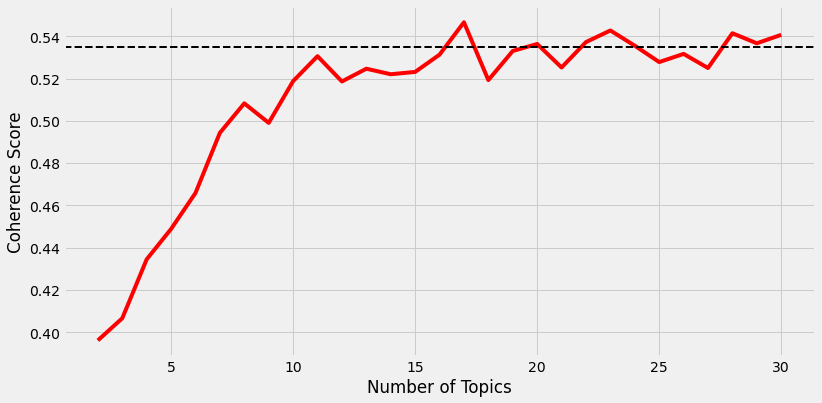

In [51]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')


x_ax = range(2, 31, 1)
y_ax = coherence_scores

plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_ax, c='r')

plt.axhline(y=0.535, c='k', linestyle='--', linewidth=2)
plt.rcParams['figure.facecolor'] = 'white'

xl = plt.xlabel('Number of Topics')
yl = plt.ylabel('Coherence Score')

plt.show()

* it looks like the score starts increasing rapidly when the number of
topics is five and gradually starts plateauing at 19 or 20.

In [52]:
best_model_idx = coherence_df[coherence_df['Number of Topics'] == 20].index[0]
best_lda_model = lda_models[best_model_idx]
best_lda_model.num_topics

20

* Let’s view all the 20 topics generated by our selected best model, similar to our
previous models.

In [53]:
topics = [[(term, round(wt, 3)) for term, wt in best_lda_model.show_topic(n, topn=20)] for n in range(0, best_lda_model.num_topics)]

for idx, topic in enumerate(topics):
  print('Topic #'+str(idx+1)+':')
  print([term for term, wt in topic])
  print()

Topic #1:
['distribution', 'probability', 'prior', 'variable', 'gaussian', 'mixture', 'estimate', 'density', 'bayesian', 'approximation', 'likelihood', 'sample', 'log', 'expert', 'em', 'estimation', 'posterior', 'step', 'component', 'probabilistic']

Topic #2:
['training', 'prediction', 'kernel', 'test', 'training_set', 'regression', 'estimate', 'selection', 'machine', 'experiment', 'sample', 'test_set', 'cross_validation', 'measure', 'ensemble', 'regularization', 'variance', 'margin', 'risk', 'pruning']

Topic #3:
['circuit', 'chip', 'current', 'analog', 'voltage', 'neuron', 'implementation', 'processor', 'bit', 'design', 'device', 'computation', 'array', 'parallel', 'neural', 'digital', 'synapse', 'operation', 'hardware', 'transistor']

Topic #4:
['image', 'feature', 'object', 'pixel', 'face', 'view', 'recognition', 'representation', 'scale', 'contour', 'surface', 'edge', 'shape', 'visual', 'part', 'scene', 'vision', 'digit', 'local', 'texture']

Topic #5:
['cell', 'response', 'activ

* A better way of visualizing the topics is to build a term-topic dataframe, as depicted.

In [54]:
topics_df = pd.DataFrame([[term for term, wt in topic] for topic in topics], columns = ['Term'+str(i) for i in range(1, 21)],
                         index=['Topic '+str(t) for t in range(1, best_lda_model.num_topics+1)]).T
topics_df

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20
Term1,distribution,training,circuit,image,cell,motion,equation,bound,vector,map,state,unit,rule,node,neuron,search,word,noise,state,local
Term2,probability,prediction,chip,feature,response,direction,solution,theorem,linear,region,dynamic,training,representation,class,signal,rate,recognition,average,control,distance
Term3,prior,kernel,current,object,activity,position,convergence,class,matrix,subject,neuron,layer,structure,classification,frequency,experiment,speech,distribution,action,cluster
Term4,variable,test,analog,pixel,stimulus,visual,gradient,threshold,component,location,memory,hidden_unit,sequence,classifier,spike,task,training,curve,step,structure
Term5,gaussian,training_set,voltage,face,neuron,target,vector,approximation,nonlinear,effect,pattern,net,symbol,pattern,channel,strategy,character,equation,policy,graph
Term6,mixture,regression,neuron,view,pattern,control,constraint,proof,signal,change,recurrent,architecture,connectionist,tree,response,table,sequence,correlation,controller,clustering
Term7,estimate,estimate,implementation,recognition,cortical,field,energy,size,source,study,attractor,pattern,language,vector,firing,application,hmm,theory,reinforcement_learning,variable
Term8,density,selection,processor,representation,layer,velocity,iteration,probability,filter,condition,module,trained,level,code,temporal,user,context,rate,environment,dimensional
Term9,bayesian,machine,bit,scale,receptive_field,movement,rate,loss,coefficient,light,capacity,task,unit,probability,stimulus,instance,speaker,limit,task,mapping
Term10,approximation,experiment,design,contour,cortex,motor,optimization,complexity,operator,experiment,connection,activation,string,feature,threshold,test,feature,stochastic,optimal,global


* Another easy way to view the topics is to create a topic-term dataframe, whereby each topic is represented in a row with the terms of the topic being represented as a comma-separated string.

In [55]:
pd.set_option('display.max_colwidth', -1)

topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Terms per Topic'],
                         index=['Topic'+str(t) for t in range(1, best_lda_model.num_topics+1)] )

topics_df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,Terms per Topic
Topic1,"distribution, probability, prior, variable, gaussian, mixture, estimate, density, bayesian, approximation, likelihood, sample, log, expert, em, estimation, posterior, step, component, probabilistic"
Topic2,"training, prediction, kernel, test, training_set, regression, estimate, selection, machine, experiment, sample, test_set, cross_validation, measure, ensemble, regularization, variance, margin, risk, pruning"
Topic3,"circuit, chip, current, analog, voltage, neuron, implementation, processor, bit, design, device, computation, array, parallel, neural, digital, synapse, operation, hardware, transistor"
Topic4,"image, feature, object, pixel, face, view, recognition, representation, scale, contour, surface, edge, shape, visual, part, scene, vision, digit, local, texture"
Topic5,"cell, response, activity, stimulus, neuron, pattern, cortical, layer, receptive_field, cortex, connection, orientation, unit, visual, spatial, contrast, simulation, mechanism, population, synaptic"
Topic6,"motion, direction, position, visual, target, control, field, velocity, movement, motor, trajectory, hand, location, arm, moving, human, response, spatial, feedback, sensory"
Topic7,"equation, solution, convergence, gradient, vector, constraint, energy, iteration, rate, optimization, update, minimum, optimal, constant, gradient_descent, eq, step, matrix, condition, derivative"
Topic8,"bound, theorem, class, threshold, approximation, proof, size, probability, loss, complexity, polynomial, theory, assume, linear, hypothesis, defined, definition, define, xi, constant"
Topic9,"vector, linear, matrix, component, nonlinear, signal, source, filter, coefficient, operator, basis, transformation, pca, ica, projection, gaussian, representation, principal_component, rule, independent"
Topic10,"map, region, subject, location, effect, change, study, condition, light, experiment, et_al, brain, pair, normal, correlation, trial, eeg, site, left, theory"


### Interpreting Topic Model Results

An interesting point to remember is, given a corpus of documents (in the form of
features, e.g., Bag of Words) and a trained topic model, you can predict the distribution of topics in each document (research paper in this case) with the following code.

In [56]:
tm_results = best_lda_model[bow_corpus]

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


CalledProcessError: ignored

In [57]:
best_lda_model.show_topics(num_topics=20)

[(0,
  '0.023*"distribution" + 0.017*"probability" + 0.016*"prior" + 0.014*"variable" + 0.013*"gaussian" + 0.013*"mixture" + 0.012*"estimate" + 0.012*"density" + 0.011*"bayesian" + 0.009*"approximation"'),
 (1,
  '0.035*"training" + 0.026*"prediction" + 0.013*"kernel" + 0.013*"test" + 0.013*"training_set" + 0.012*"regression" + 0.010*"estimate" + 0.008*"selection" + 0.007*"machine" + 0.007*"experiment"'),
 (2,
  '0.029*"circuit" + 0.021*"chip" + 0.017*"current" + 0.016*"analog" + 0.014*"voltage" + 0.014*"neuron" + 0.010*"implementation" + 0.009*"processor" + 0.009*"bit" + 0.008*"design"'),
 (3,
  '0.078*"image" + 0.031*"feature" + 0.030*"object" + 0.018*"pixel" + 0.013*"face" + 0.012*"view" + 0.009*"recognition" + 0.008*"representation" + 0.008*"scale" + 0.007*"contour"'),
 (4,
  '0.052*"cell" + 0.020*"response" + 0.019*"activity" + 0.019*"stimulus" + 0.017*"neuron" + 0.015*"pattern" + 0.011*"cortical" + 0.011*"layer" + 0.011*"receptive_field" + 0.010*"cortex"'),
 (5,
  '0.027*"motion"

### overcome the problem

In [58]:
opt_lda_model = gensim.models.wrappers.LdaMallet(mallet_path=MALLET_PATH, corpus=bow_corpus,
                                              num_topics=20, id2word=dictionary,
                                               iterations=500, workers=16)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [59]:
tm_results = opt_lda_model[bow_corpus]

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


We can now get the most dominant topic per research paper with some intelligent sorting and indexing using the following code.

In [60]:
tm_results

[[(0, 0.017918381344307274),
  (1, 0.035751028806584366),
  (2, 0.35965363511659815),
  (3, 0.015346364883401922),
  (4, 0.010030864197530865),
  (5, 0.03506515775034294),
  (6, 0.016718106995884777),
  (7, 0.008659122085048012),
  (8, 0.08170438957475996),
  (9, 0.00934499314128944),
  (10, 0.0700445816186557),
  (11, 0.012602880658436216),
  (12, 0.018775720164609058),
  (13, 0.012259945130315503),
  (14, 0.024091220850480113),
  (15, 0.013117283950617285),
  (16, 0.06815843621399179),
  (17, 0.06987311385459535),
  (18, 0.07518861454046641),
  (19, 0.04569615912208506)],
 [(0, 0.014034406933126374),
  (1, 0.03304876471349114),
  (2, 0.07288837149139826),
  (3, 0.28592678825507695),
  (4, 0.00795498641831587),
  (5, 0.09785280041391799),
  (6, 0.012223515715948778),
  (7, 0.005626697710516104),
  (8, 0.205600827835985),
  (9, 0.00692019143707153),
  (10, 0.011576768852671065),
  (11, 0.007566938300349243),
  (12, 0.051933773121200365),
  (13, 0.07107748027422067),
  (14, 0.0137757081

In [61]:
len(tm_results)

1740

In [62]:
corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] for topics in tm_results]

corpus_topics

[(2, 0.35965363511659815),
 (3, 0.28592678825507695),
 (8, 0.18612030905077262),
 (2, 0.41063540604825),
 (13, 0.19340077071290945),
 (4, 0.41055410879629634),
 (13, 0.32312413879493923),
 (10, 0.7243379295250602),
 (10, 0.3570698625046452),
 (7, 0.29073327359617684),
 (10, 0.4788305881021114),
 (17, 0.4660299468233976),
 (2, 0.4663615928066795),
 (9, 0.2580542871638762),
 (10, 0.6440750213128731),
 (3, 0.3215112433862434),
 (17, 0.4347050754458162),
 (2, 0.2075788061703555),
 (8, 0.4457040572792363),
 (10, 0.35775765705343165),
 (12, 0.24429839343893944),
 (10, 0.5653870162297128),
 (8, 0.24932432432432433),
 (3, 0.2942518248175183),
 (14, 0.20918367346938782),
 (1, 0.3179192838062234),
 (5, 0.1955819756348158),
 (13, 0.45717884130982367),
 (12, 0.35426149040606875),
 (17, 0.24637146371463714),
 (3, 0.27259978425026976),
 (12, 0.2524639485423799),
 (8, 0.40986672106623134),
 (8, 0.4803094233473979),
 (0, 0.16962659380692172),
 (7, 0.21963383838383838),
 (3, 0.3049269636015325),
 (5, 0

In [63]:
len(corpus_topics)

1740

This provides a plethora of options that can be leveraged to extract useful insights from our corpus of research papers. To enable this, we construct a master dataframe that will hold the base statistics, which we use soon to depict different useful insights.

In [0]:
corpus_topic_df = pd.DataFrame()

corpus_topic_df['Document'] = range(0, len(papers))

corpus_topic_df['Dominant Topic'] = [item[0]+1 for item in corpus_topics]

corpus_topic_df['Contribution %'] = [round(item[1]*100, 2) for item in corpus_topics]

corpus_topic_df['Topic Desc'] = [topics_df.iloc[t[0]]['Terms per Topic'] for t in corpus_topics]

corpus_topic_df['Paper'] = papers

In [100]:
corpus_topic_df

,Document,Dominant Topic,Contribution %,Topic Desc,Paper
0,0,3,35.97000,"circuit, chip, current, analog, voltage, neuron, implementation, processor, bit, design, device, computation, array, parallel, neural, digital, synapse, operation, hardware, transistor","1 \nCONNECTIVITY VERSUS ENTROPY \nYaser S. Abu-Mostafa \nCalifornia Institute of Technology \nPasadena, CA 91125 \nABSTRACT \nHow does the connectivity of a neural network (number of synapses per ..."
1,1,4,28.59000,"image, feature, object, pixel, face, view, recognition, representation, scale, contour, surface, edge, shape, visual, part, scene, vision, digit, local, texture",22 \nLEARNING ON A GENERAL NETWORK \nAmir F. Atiya \nDepartment of Electrical Engineering \nCalifornia Institute of Technology \nCa 91125 \nAbstract \nThis paper generalizes the backpropagation me...
2,2,9,18.61000,"vector, linear, matrix, component, nonlinear, signal, source, filter, coefficient, operator, basis, transformation, pca, ica, projection, gaussian, representation, principal_component, rule, indep...",31 \nAN ARTIFICIAL NEURAL NETWORK FOR SPATIO- \nTEMPORAL BIPOLAR PATTERNS: APPLICATION TO \nPHONEME CLASSIFICATION \nToshiteru Homma \nLes E. Atlas \nRobert J. Marks H \nInteractive Systems Design...
3,3,3,41.06000,"circuit, chip, current, analog, voltage, neuron, implementation, processor, bit, design, device, computation, array, parallel, neural, digital, synapse, operation, hardware, transistor","41 \nON PROPERTIES OF NETWORKS \nOF NEURON-LIKE ELEMENTS \nPierre Baldi* and Santosh S. Venlmtesh I \n15 December 1987 \nAbstract \nThe complexity and computational capacity of multi-layered, feed..."
4,4,14,19.34000,"node, class, classification, classifier, pattern, tree, vector, code, probability, feature, bit, sample, label, binary, decision, stage, labeled, decision_tree, technique, error_rate","52 \nSupervised Learning of Probability Distributions \nby Neural Networks \nEric B. Baum \nJet Propulsion Laboratory, Pasadena CA 91109 \nFrank Wilczek \nDepartment of Physics,Harvard University..."
...,...,...,...,...,...
1735,1735,19,33.25000,"state, control, action, step, policy, controller, reinforcement_learning, environment, task, optimal, goal, robot, reward, td, agent, trial, transition, current, reinforcement, rl","Coastal Navigation with Mobile Robots \nNicholas Roy and Sebastian Thrun \nSchool of Computer Science \nCarnegie Mellon University \nPittsburgh, PA 15213 \n{ nicholas. roy I sebastian. thrun } @ c..."
1736,1736,19,34.11000,"state, control, action, step, policy, controller, reinforcement_learning, environment, task, optimal, goal, robot, reward, td, agent, trial, transition, current, reinforcement, rl",Learning Factored Representations for Partially \nObservable Markov Decision Processes \nBrian Sallans \nDepartment of Computer Science \nUniversity of Toronto \nToronto M5S 2Z9 Canada \nGatsby Co...
1737,1737,19,48.52000,"state, control, action, step, policy, controller, reinforcement_learning, environment, task, optimal, goal, robot, reward, td, agent, trial, transition, current, reinforcement, rl","Policy Gradient Methods for \nReinforcement Learning with Function \nApproximation \nRichard S. Sutton, David McAllester, Satinder Singh, Yishay Mansour \nAT&T Labs - Research, 180 Park Avenue, Fl..."
1738,1738,19,48.61000,"state, control, action, step, policy, controller, reinforcement_learning, environment, task, optimal, goal, robot, reward, td, agent, trial, transition, current, reinforcement, rl","Monte Carlo POMDPs \nSebastian Thrun \nSchool of Computer Science \nCarnegie Mellon University \nPittsburgh, PA 15213 \nAbstract \nWe present a Monte Carlo algorithm for learning to act in partial..."


In [66]:
corpus_topic_df.describe()

,Document,Dominant Topic,Contribution %
count,1740.000000,1740.000000,1740.000000
mean,869.500000,11.202299,36.624563
std,502.439051,5.912180,12.537420
min,0.000000,1.000000,12.040000
25%,434.750000,6.000000,27.280000
50%,869.500000,11.000000,34.660000
75%,1304.250000,16.250000,44.247500
max,1739.000000,20.000000,77.340000


In [67]:
corpus_topic_df['Dominant Topic'].value_counts()

20    156
11    117
18    110
12    110
5     108
19    100
3     98 
4     96 
9     86 
16    86 
7     84 
10    78 
14    77 
13    73 
15    72 
17    69 
8     65 
1     65 
2     64 
6     26 
Name: Dominant Topic, dtype: int64

In [0]:
trial_df = corpus_topic_df.copy()

In [0]:
trial_df.drop(['Paper', 'Topic Desc'], axis=1, inplace=True)

In [94]:
trial_df

,Document,Dominant Topic,Contribution %
0,0,3,35.97000
1,1,4,28.59000
2,2,9,18.61000
3,3,3,41.06000
4,4,14,19.34000
...,...,...,...
1735,1735,19,33.25000
1736,1736,19,34.11000
1737,1737,19,48.52000
1738,1738,19,48.61000


### Dominant Topics Distribution Across Corpus

The first thing we can do is look at the overall distribution of each topic across the corpus of research papers.

In [102]:
corpus_topic_df.columns

Index(['Document', 'Dominant Topic', 'Contribution %', 'Topic Desc', 'Paper'], dtype='object')

In [0]:
pd.set_option('display.max_colwidth', 200)

In [105]:
topic_stats_df = corpus_topic_df.groupby('Dominant Topic').agg(
                                  Doc_Count = ('Dominant Topic', np.size),
                                  Total_Docs_Perc = ('Dominant Topic', np.size)).reset_index()

# topic_stats_df = topic_stats_df['Dominant Topic'].reset_index()

topic_stats_df['Total_Docs_Perc'] = topic_stats_df['Total_Docs_Perc'].apply(lambda row: round((row*100) / len(papers), 2))
topic_stats_df['Topic Desc'] = [topics_df.iloc[t]['Terms per Topic'] for t in range(len(topic_stats_df))]

topic_stats_df

,Dominant Topic,Doc_Count,Total_Docs_Perc,Topic Desc
0,1,65,3.74000,"neuron, circuit, signal, chip, current, analog, voltage, channel, noise, vlsi, pulse, implementation, synapse, fig, frequency, delay, gain, potential, synaptic, control"
1,2,64,3.68000,"image, feature, structure, layer, state, neuron, local, distribution, cell, motion, recognition, object, node, net, matrix, gaussian, sequence, size, line, hidden"
2,3,98,5.63000,"sound, auditory, template, frequency, motor, acoustic, syllable, song, production, harmonic, nucleus, spectrogram, representation, temporal, phase, hearing, bird, template matching, khz, control"
3,4,96,5.52000,"cell, neuron, visual, response, stimulus, activity, field, spike, motion, direction, cortex, orientation, map, spatial, eye, synaptic, firing, cortical, fig, rate"
4,5,108,6.21000,"image, feature, recognition, layer, hidden, task, representation, object, trained, test, net, classification, classifier, architecture, class, level, rule, hidden unit, experiment, speech"
5,6,26,1.49000,"state, dynamic, equation, matrix, rule, gradient, recurrent, solution, signal, hidden, fixed, source, component, attractor, field, energy, eq, phase, fixed point, transition"
6,7,84,4.83000,"sequence, markov, chain, structure, markov model, prediction, hmms, protein, hidden markov, region, state, hidden, bengio, site, gene, class, length, receptor, human, mouse"
7,8,65,3.74000,"word, context, speech, language, phoneme, similarity, letter, item, state, probability, node, phone, list, vocabulary, acoustic, activation, connectionist, duration, proximity, short"
8,9,86,4.94000,"activation, behavior, winner, take, active, winner take, competitive, connection, role, binding, activity, wta, self, distributed, level, activation function, body, sensor, competition, food"
9,10,78,4.48000,"state, cell, distribution, neuron, probability, control, response, layer, rate, signal, task, architecture, random, test, hidden, image, change, fig, generalization, field"


### Dominant Topics in Specific Research Papers

Another interesting perspective is to select specific papers, view the most dominant topic in each of those papers, and see if that makes sense.

In [70]:
pd.set_option('display.max_colwidth', 200)
(corpus_topic_df[corpus_topic_df['Document'].isin([681, 9, 392, 1622, 17, 906, 996, 503, 13, 733])])

,Document,Dominant Topic,Contribution %,Topic Desc,Paper
9,9,8,29.07,"bound, theorem, class, threshold, approximation, proof, size, probability, loss, complexity, polynomial, theory, assume, linear, hypothesis, defined, definition, define, xi, constant","103 \nNEURAL NETWORKS FOR TEMPLATE MATCHING: \nAPPLICATION TO REAL-TIME CLASSIFICATION \nOF THE ACTION POTENTIALS OF REAL NEURONS \nYiu-fai Wong, Jashojiban Banik]. and James M. Bower$ \n]'Divisi..."
13,13,10,25.81,"map, region, subject, location, effect, change, study, condition, light, experiment, et_al, brain, pair, normal, correlation, trial, eeg, site, left, theory","144 \nSPEECH RECOGNITION EXPERIMENTS \nWITH PERCEPTRONS \nD. J. Burr \nBell Communications Research \nMorristown, NJ 07960 \nABSTRACT \nArtificial neural networks (ANNs) are capable of accurate re..."
17,17,3,20.76,"circuit, chip, current, analog, voltage, neuron, implementation, processor, bit, design, device, computation, array, parallel, neural, digital, synapse, operation, hardware, transistor","219 \nNetwork Generality, Training Required, \nand Precision Required \nJohn S. Denker and Ben S. Wittner \nAT&T Bell Laboratories \nHolmdel, New Jersey 07733 \nKeep your hand on your wa]let. \n--..."
392,392,16,36.46,"search, rate, experiment, task, strategy, table, application, user, instance, test, run, random, call, technique, average, block, feature, high, good, program","Using Genetic Algorithms to Improve \nPattern Classification Performance \nEric I. Chang and Richard P. Lippmann \nLincoln Laboratory, MIT \nLexington, MA 02173-9108 \nAbstract \nGenetic algorithm..."
503,503,8,39.50,"bound, theorem, class, threshold, approximation, proof, size, probability, loss, complexity, polynomial, theory, assume, linear, hypothesis, defined, definition, define, xi, constant",Neural Network Analysis of Event Related \nPotentials and Electroencephalogram Predicts \nVigilance \nRita Venturini \nWilliam W. Lytton \nTerrence J. Sejnowski \nComputational Neurobiology Labora...
681,681,13,32.77,"rule, representation, structure, sequence, symbol, connectionist, language, level, unit, string, activation, context, pattern, role, similarity, represented, task, learned, note, part","Mapping Between Neural and Physical \nActivities of the Lobster Gastric Mill \nKenji Doya \nMary E.T. Boyle \nAllen I. Selverston \nDepartment of Biology \nUniversity of California, San Diego \nLa..."
733,733,14,24.11,"node, class, classification, classifier, pattern, tree, vector, code, probability, feature, bit, sample, label, binary, decision, stage, labeled, decision_tree, technique, error_rate",Optimal Brain Surgeon: \nExtensions and performance comparisons \nBabak Hassibi* \nDavid G. Stork \nGregory Wolff \nTakahiro Watanabe \nRicoh California Research Center \n2882 Sand Hill Road Suite...
906,906,15,26.05,"neuron, signal, frequency, spike, channel, response, firing, temporal, stimulus, threshold, current, rate, neural, synaptic, auditory, event, amplitude, sound, phase, firing_rate","Extracting Rules from Artificial Neural Networks \nwith Distributed Representations \nSebastian Thrun \nUniversity of Bonn \nDepartment of Computer Science III \nR6merstr. 164, D-53117 Bonn, Germa..."
996,996,13,36.36,"rule, representation, structure, sequence, symbol, connectionist, language, level, unit, string, activation, context, pattern, role, similarity, represented, task, learned, note, part",A Dynamical Model of Context Dependencies for the \nVestibulo-Ocular Reflex \nO!ivier J.M.D. Coenen* \nTerrence J. Sejnowskit \nComputational Neurobiology Laboratory \nHoward Hughes Medical Instit...
1622,1622,7,50.22,"equation, solution, convergence, gradient, vector, constraint, energy, iteration, rate, optimization, update, minimum, optimal, constant, gradient_descent, eq, step, matrix, condition, derivative","Model Selection for Support Vector Machines \nOlivier Chapelle*,t, Vladimir Vapnik* \n* AT&T Research Labs, Red Bank, NJ \nt LIP6, Paris, France \n{ chapelle

### Relevant Research Papers per Topic Based on Dominance



In [109]:
corpus_topic_df.groupby('Dominant Topic').apply(lambda topic_set: (topic_set.sort_values(by=['Contribution %'], ascending=False).iloc[0])).reset_index(drop=True)

,Document,Dominant Topic,Contribution %,Topic Desc,Paper
0,706,1,62.49000,"distribution, probability, prior, variable, gaussian, mixture, estimate, density, bayesian, approximation, likelihood, sample, log, expert, em, estimation, posterior, step, component, probabilistic","When Will a Genetic Algorithm \nOutperform Hill Climbing? \nMelanie Mitchell \nSanta Fe Institute \n1660 Old Pecos Trail, Suite A \nSanta Fe, NM 87501 \nJohn H. Holland \nDept. of Psychology \nUni..."
1,1705,2,45.66000,"training, prediction, kernel, test, training_set, regression, estimate, selection, machine, experiment, sample, test_set, cross_validation, measure, ensemble, regularization, variance, margin, ris...",Emergence of Topography and Complex \nCell Properties from Natural Images \nusing Extensions of ICA \nAapo HyvSrinen and Patrik Hoyer \nNeural Networks Research Center \nHelsinki University of Tec...
2,534,3,77.34000,"circuit, chip, current, analog, voltage, neuron, implementation, processor, bit, design, device, computation, array, parallel, neural, digital, synapse, operation, hardware, transistor","Polynomial Uniform Convergence of \nRelative Frequencies to Probabilities \nAlberto Bertoni, Paola Campadelll;' Anna Morpurgo, Sandra Panlzza \nDipartimento di Scienze dell'Informazione \nUniversi..."
3,867,4,60.11000,"image, feature, object, pixel, face, view, recognition, representation, scale, contour, surface, edge, shape, visual, part, scene, vision, digit, local, texture","H Optimal Training Algorithms and \ntheir Relation to Backpropagation \nBabak Hassibi* \nInformation Systems Laboratory \nStanford University \nStanford, CA 94305 \nThomas Kailath \nInformation Sy..."
4,1133,5,69.68000,"cell, response, activity, stimulus, neuron, pattern, cortical, layer, receptive_field, cortex, connection, orientation, unit, visual, spatial, contrast, simulation, mechanism, population, synaptic","A model of transparent motion and \nnon-transparent motion aftereffects \nAlexander Grunewald* \nMax-Planck Institut fiir biologische Kybernetik \nSpemannstral]e 38 \nD-72076 Tiibingen, Germany \n..."
5,286,6,45.52000,"motion, direction, position, visual, target, control, field, velocity, movement, motor, trajectory, hand, location, arm, moving, human, response, spatial, feedback, sensory","Further Studies of a Model for the \nDevelopment and Regeneration \nof Eye-Brain Maps \nJ.D. Cowan & A.E. Friedman \nDepartment of Mathematics, Committee on \nNeurobiology, and Brain Research Inst..."
6,1488,7,52.45000,"equation, solution, convergence, gradient, vector, constraint, energy, iteration, rate, optimization, update, minimum, optimal, constant, gradient_descent, eq, step, matrix, condition, derivative","Semi-Supervised Support Vector \nMachines \nKristin P. Bennett \nDepartment of Mathematical Sciences \nRensselaer Polytechnic Institute \nTroy, NY 12180 bennek@rpi.edu \nAyhan Demiriz \nDepartment..."
7,1697,8,66.23000,"bound, theorem, class, threshold, approximation, proof, size, probability, loss, complexity, polynomial, theory, assume, linear, hypothesis, defined, definition, define, xi, constant","Spectral Cues in Human Sound Localization \nCraig T. Jin \nDepartment of Physiology and \nDepartment of Electrical Engineering, \nUniv. of Sydney, NSW 2006, Australia \nAnna Corderoy \nDepartment ..."
8,139,9,63.40000,"vector, linear, matrix, component, nonlinear, signal, source, filter, coefficient, operator, basis, transformation, pca, ica, projection, gaussian, representation, principal_component, rule, indep...","568 \nDYNAMICS OF ANALOG NEURAL \nNETWORKS WITH TIME DELAY \nC.M. Marcus and R.M. Westervelt \nDivision of Applied Sciences and Department of Physics \nHarvard University, Cambridge Massachusetts ..."
9,658,10,69.38000,"map, region, subject, location, effect, change, study, condition, light, experiment, et_al, brain, pair, normal, correlation, trial, eeg, site, left, theory","Connected Letter Recognition with a \nMulti-State Time Delay Neural Network \nHer

## Topic Models with Scikit-Learn

### Text Representation with Feature Engineering

In [71]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=20, max_df=0.6, ngram_range=(1,2), token_pattern=None, tokenizer=lambda doc: doc,
                     preprocessor=lambda doc: doc)

cv_features = cv.fit_transform(norm_papers)

cv_features.shape

(1740, 14408)

In [72]:
# validating vocabulary size
vocabulary = np.array(cv.get_feature_names())
print('Total Vocabulary Size:', len(vocabulary))

Total Vocabulary Size: 14408


### Latent Dirichlet Allocation

In [0]:
TOTAL_TOPICS = 20

In [0]:
from sklearn.decomposition import LatentDirichletAllocation

lda_model = LatentDirichletAllocation(n_components =TOTAL_TOPICS, max_iter=500, max_doc_update_iter=50, learning_method='online',
                                      batch_size=1740, learning_offset=50., random_state=42, n_jobs=16)


In [0]:
# document_topics = lda_model.fit_transform(cv_features)

In [0]:
# pickle.dump(document_topics, open("drive/My Drive/nipstxt/document_topics.pkl", "wb"))

In [0]:
document_topics = pickle.load(open("drive/My Drive/nipstxt/document_topics.pkl", "rb"))

We can then obtain the topic-term matrix and build a dataframe from it to showcase the topics and terms in an easy-to-interpret format

In [0]:
top_terms = 20

In [79]:
topic_terms = lda_model.components_

topic_key_term_idxs = np.argsort(-np.absolute(topic_terms), axis=1)[:, :top_terms]
topic_keyterms = vocabulary[topic_key_term_idxs]
topics = [', '.join(topic) for topic in topic_keyterms]

pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame(topics, columns = ['Terms per Topic'], index=['Topic'+str(t) for t in range(1, TOTAL_TOPICS+1)])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  import sys


In [80]:
topics_df

,Terms per Topic
Topic1,"neuron, circuit, signal, chip, current, analog, voltage, channel, noise, vlsi, pulse, implementation, synapse, fig, frequency, delay, gain, potential, synaptic, control"
Topic2,"image, feature, structure, layer, state, neuron, local, distribution, cell, motion, recognition, object, node, net, matrix, gaussian, sequence, size, line, hidden"
Topic3,"sound, auditory, template, frequency, motor, acoustic, syllable, song, production, harmonic, nucleus, spectrogram, representation, temporal, phase, hearing, bird, template matching, khz, control"
Topic4,"cell, neuron, visual, response, stimulus, activity, field, spike, motion, direction, cortex, orientation, map, spatial, eye, synaptic, firing, cortical, fig, rate"
Topic5,"image, feature, recognition, layer, hidden, task, representation, object, trained, test, net, classification, classifier, architecture, class, level, rule, hidden unit, experiment, speech"
Topic6,"state, dynamic, equation, matrix, rule, gradient, recurrent, solution, signal, hidden, fixed, source, component, attractor, field, energy, eq, phase, fixed point, transition"
Topic7,"sequence, markov, chain, structure, markov model, prediction, hmms, protein, hidden markov, region, state, hidden, bengio, site, gene, class, length, receptor, human, mouse"
Topic8,"word, context, speech, language, phoneme, similarity, letter, item, state, probability, node, phone, list, vocabulary, acoustic, activation, connectionist, duration, proximity, short"
Topic9,"activation, behavior, winner, take, active, winner take, competitive, connection, role, binding, activity, wta, self, distributed, level, activation function, body, sensor, competition, food"
Topic10,"state, cell, distribution, neuron, probability, control, response, layer, rate, signal, task, architecture, random, test, hidden, image, change, fig, generalization, field"


In [81]:
document_topics

array([[1.11136254e-01, 5.46448087e-05, 5.46448092e-05, ...,
        1.09085503e-01, 5.46448087e-05, 3.14819834e-02],
       [3.64727081e-02, 3.82262997e-05, 3.82263000e-05, ...,
        3.82263007e-05, 3.82262997e-05, 1.12696440e-02],
       [3.35975607e-01, 2.89855072e-05, 2.89855079e-05, ...,
        2.89855081e-05, 2.89855072e-05, 2.89855079e-05],
       ...,
       [3.45303872e-05, 3.45303867e-05, 3.45303868e-05, ...,
        8.50024988e-01, 3.45303867e-05, 1.43080027e-02],
       [2.74574415e-05, 2.74574410e-05, 2.74574410e-05, ...,
        7.53014926e-01, 2.74574410e-05, 2.74574413e-05],
       [3.53857048e-05, 3.53857042e-05, 3.53857042e-05, ...,
        3.53857048e-05, 3.53857042e-05, 3.53857049e-05]])

In [82]:
dt_df = pd.DataFrame(document_topics,
columns=['T'+str(i) for i in range(1, TOTAL_TOPICS+1)])

pd.options.display.float_format = '{:,.5f}'.format
pd.set_option('display.max_colwidth', 200)

max_contrib_topics = dt_df.max(axis=0)
dominant_topics = max_contrib_topics.index
contrib_perc = max_contrib_topics.values
document_numbers = [dt_df[dt_df[t] == max_contrib_topics.loc[t]].index[0] for t in dominant_topics]
documents = [papers[i] for i in document_numbers]

results_df = pd.DataFrame( {'Dominant Topic': dominant_topics, 'Contribution %': contrib_perc, 'Paper Num': document_numbers,
                            'Topic': topics_df['Terms per Topic'], 'Paper Name': documents})

results_df

,Dominant Topic,Contribution %,Paper Num,Topic,Paper Name
Topic1,T1,0.99727,1076,"neuron, circuit, signal, chip, current, analog, voltage, channel, noise, vlsi, pulse, implementation, synapse, fig, frequency, delay, gain, potential, synaptic, control","Improved Silicon Cochlea \nusing \nCompatible Lateral Bipolar Transistors \nAndr6 van Schaik, Eric Fragnire, Eric Vittoz \nMANTRA Center for Neuromimetic Systems \nSwiss Federal Institute of Tech..."
Topic2,T2,0.00033,181,"image, feature, structure, layer, state, neuron, local, distribution, cell, motion, recognition, object, node, net, matrix, gaussian, sequence, size, line, hidden",794 \nNEURAL ARCHITECTURE \nValentino Braitenberg \nMax Planck Institute \nFederal Republic of Germany \nABSTRACT\nWhile we are waiting for the ultimate biophysics of cell membranes and synapses \...
Topic3,T3,0.82975,182,"sound, auditory, template, frequency, motor, acoustic, syllable, song, production, harmonic, nucleus, spectrogram, representation, temporal, phase, hearing, bird, template matching, khz, control",795 \nSONG LEARNING IN BIRDS \nM. Konishi \nDivision of Biology \nCalifornia Institute of Technology \nABSTRACT\nBirds sing to communicate. Male birds use song to advertise their territories and \...
Topic4,T4,0.99947,1609,"cell, neuron, visual, response, stimulus, activity, field, spike, motion, direction, cortex, orientation, map, spatial, eye, synaptic, firing, cortical, fig, rate",Can V1 mechanisms account for \nfigure-ground and medial axis effects? \nZhaoping Li \nGatsby Computational Neuroscience Unit \nUniversity College London \nzhaopinggat shy. ucl. ac. uk \nAbstract...
Topic5,T5,0.99949,213,"image, feature, recognition, layer, hidden, task, representation, object, trained, test, net, classification, classifier, architecture, class, level, rule, hidden unit, experiment, speech","266 Zemel, Mozer and Hinton \nTRAFFIC: Recognizing Objects Using \nHierarchical Reference Frame Transformations \nRichard S. Zemel \nComputer Science Dept. \nUniversity of Toronto \nToronto, ONT M..."
Topic6,T6,0.98120,988,"state, dynamic, equation, matrix, rule, gradient, recurrent, solution, signal, hidden, fixed, source, component, attractor, field, energy, eq, phase, fixed point, transition","Harmony Networks Do Not Work \nRen5 Gourley \nSchool of Computing Science \nSimon Fraser University \nBurnaby, B.C., V5A 1S6, Canada \ngourley@mprgate.mpr.ca \nAbstract \nHarmony networks have be..."
Topic7,T7,0.99956,271,"sequence, markov, chain, structure, markov model, prediction, hmms, protein, hidden markov, region, state, hidden, bengio, site, gene, class, length, receptor, human, mouse","A Neural Network to Detect \nHomologies in Proteins \nYoshua Bengio \nSchool of Computer Science \nMcGill University \nMontreal, Canada H3A 2A7 \nSamy Bengio \nDepartement d'Informatique \nUnivers..."
Topic8,T8,0.96324,850,"word, context, speech, language, phoneme, similarity, letter, item, state, probability, node, phone, list, vocabulary, acoustic, activation, connectionist, duration, proximity, short","A solvable connectionist model of \nimmediate recall of ordered lists \nNell Burgess \nDepartment of Anatomy, University College London \nLondon WCiE 6BT, England \n(e-mail: n .burgessucl. ac. uk..."
Topic9,T9,0.99938,466,"activation, behavior, winner, take, active, winner take, competitive, connection, role, binding, activity, wta, self, distributed, level, activation function, body, sensor, competition, food","Dynamically-Adaptive Winner-Take-All Networks \nTret E. Lange \nComputer Scienos Department \nUniversity of California, Los Angeles, CA 90024 \nAbstract \nWinner-Take-All (WTA) networks, in which..."
Topic10,T10,0.00033,181,"state, cell, distribution, neuron, probability, control, response, layer, rate, signal, task, architecture, random, test, hidden, image, change, fig, generalization, field",794 \nNEURAL ARCHITECTURE \nValentino Braitenberg \nMax Planck Institute \nFederal Republic of Germany \nABSTRACT\n

* Viewing each topic and corresponding paper with its maximum
contribution

### WordClouds

In [0]:
from wordcloud import WordCloud

In [0]:
# wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
#                max_font_size=150, random_state=42)

In [0]:
wc = WordCloud(background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

In [0]:
plt.rcParams['figure.figsize'] = [20, 15]

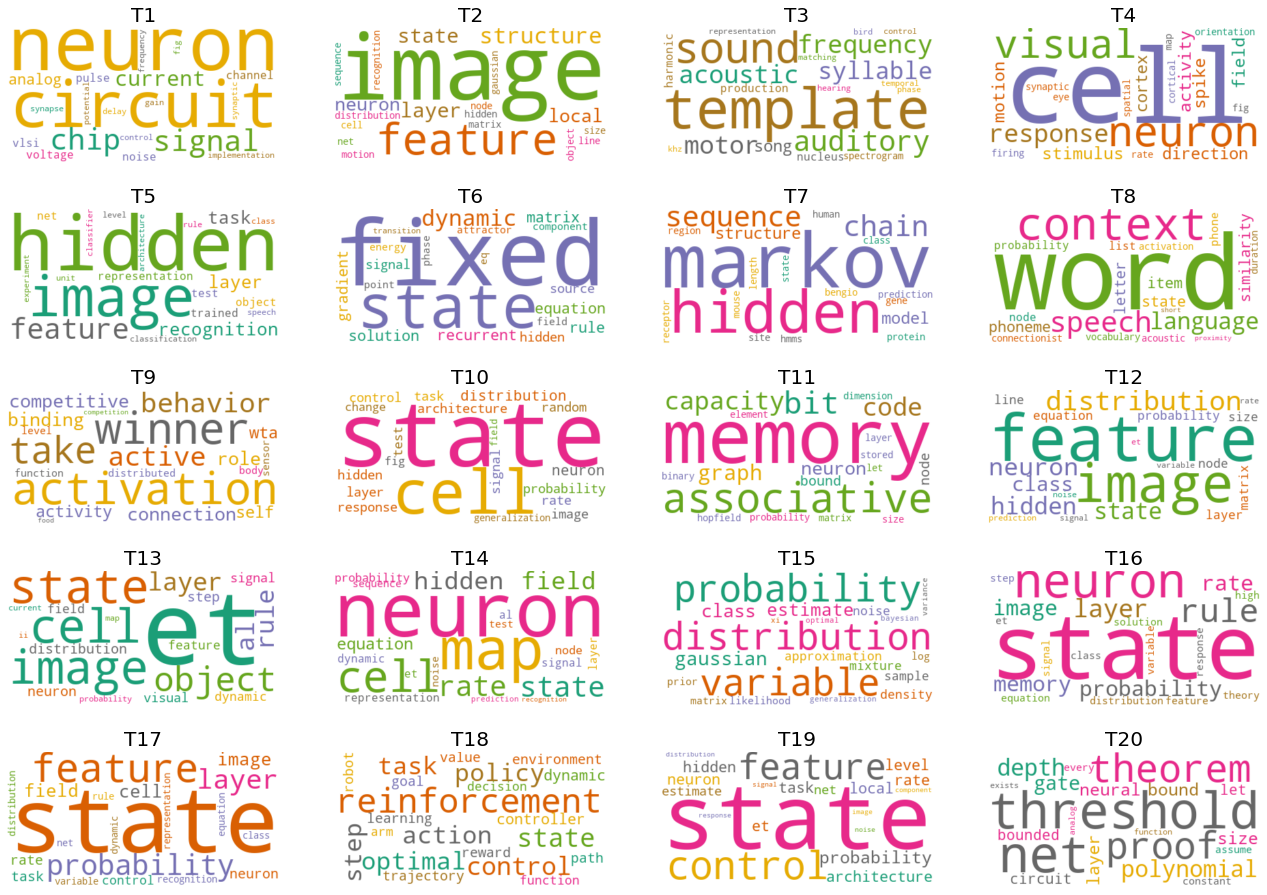

In [87]:
# Create subplots for each comedian
i=0
for i in range(20):

    wc.generate(text=results_df["Topic"][i])
    
    plt.subplot(5, 4, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(results_df["Dominant Topic"][i])
    # print(topic)
    # print(type(topic))
    # print()
    # print()

plt.show()